# Introduction
Time series data is data that changes over time. Whether it be stock market fluctuations, sensor data recording climate change, or activity in the brain, any signal that changes over time can be described as a time series. Machine learning is about finding patterns in data and making predictions. It has emerged as a powerful method for leveraging complexity in data in order to generate predictions and insights into the problem one is trying to solve. This project is about a machine learning pipeline in the time series context. It covers feature engineering, common features that are extracted from time series in order to do machine learning; model fitting, i.e., models that are suitable for time series data; prediction and validation, in particular, what special consideration should be considered in validation of the model regarding the fact that features are changing over time.

We're going to work on two datasets: the heartbeat acoustic dataset for classification and the stock data for regression.

# The heartbeat acoustic data
The first dataset is audio data. It was originally offered as a part of a public [Kaggle competition](https://www.kaggle.com/kinguistics/heartbeat-sounds). It's a collection of heartbeat sounds. Hearts normally have a predictable sound pattern as they beat, but some disorders can cause the heart to beat abnormally. Can we find the 'abnormal' heart beats? This dataset contains a training set with labels for each type of heartbeat, and a testing set with no labels. We'll use the testing set to validate our models.

**Createing a time array**<br>
#create an array of indices, one for each sample, and divide by the sampling frequency<br>
indices=np.arange(0,len(audio))<br>
time=indices/sfreq

#find the time stamp for the N-1th data point. THen use linspace() to interpolate from 0 to that time.<br>
final_time=(len(audio)-1)/sfreq<br>
time=np.linspace(0,final_time,sfreq)

In [3]:
import librosa as lr #library to load wav files
from glob import glob #library to list files that match a given pattern.
import matplotlib.pyplot as plt
%matplotlib inline

# List all the wav files in the folder
fp='/Users/phyhouhou/audiodata'
audio_files = glob(fp + '/*.wav')

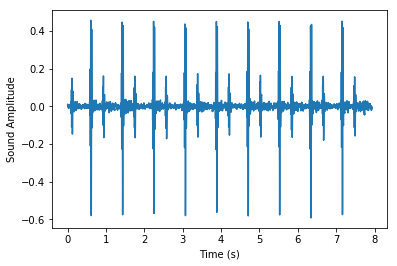

In [98]:
import numpy as np

# Read in the first audio file, create the time array
audio0, sfreq0 = lr.load(audio_files[0]) #audio contains the data and sfreq is the sampling frequency
time0 = np.arange(0, len(audio0)) / sfreq0

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time0, audio0)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

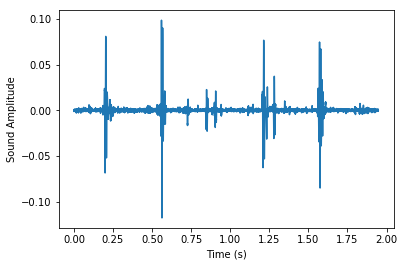

In [53]:
audio3, sfreq3 = lr.load(audio_files[3])
time = np.arange(0, len(audio3)) / sfreq2

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio3)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

There are several seconds of heartbeat sounds in here, though note that most of this time is silence. A common procedure in machine learning is to separate the datapoints with lots of stuff happening from the ones that don't

Two DataFrames, normal and abnormal, each with the shape of (n_times_points, n_audio_files) containing the audio for several heartbeats are available in your workspace. Also, the sampling frequency is loaded into a variable called sfreq. A convenience plotting function show_plot_and_make_titles() is also available in your workspace.

First, create the time array for these audio files (all audios are the same length).
Then, stack the values of the two DataFrames together (normal and abnormal, in that order) so that we have a single array of shape (n_audio_files, n_times_points).
Finally, use the code provided to loop through each list item / axis, and plot the audio over time in the corresponding axis object.
We plot normal heartbeats in the left column, and abnormal ones in the right column

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(len(normal)) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal,abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

![png](img/hb.png)

 As you can see there is a lot of variability in the raw data, let's see if we can average out some of that noise to notice a difference.
# Invariance in time
While we should always start by visualizing the raw data, this is often uninformative when it comes to discriminating between two classes of data points. Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.

Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).

So we will average across many instances of each class of heartbeat sound.

In [ ]:
# Average across the time dimension of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time,mean_normal )
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

![png](img/hbavg.png)

# Build a classification model
While eye-balling differences is a useful way to gain an intuition for the data, let's see if you can operationalize things with a model. We will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data.

We've split the two DataFrames (normal and abnormal) into X_train, X_test, y_train, and y_test.

In [ ]:
from sklearn.svm import LinearSVC

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train,y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

0.555555555556<br>
Note that our predictions didn't do so well. That's because the features we're using as inputs to the model (raw data) aren't very good at differentiating classes. Next, we'll explore how to calculate some more complex features that may improve the results.

# Improving features for classification
We will work out features that are unique for time series data.
* the auditory envelope<br>
we will smooth the data to calculate the auditory envelope. Instead of averaging over all time, we can do local average. This is called smoothing our timeseries. It removes short-term noise, while retaining the general pattern.

* calculating a rolling window statistic<br>
window_size=20<br>
windowed=audio.rolling(window=window_size)<br>
audio_smooth=windowed.mean()


# Calculating the envelope of sound
One of the ways we can improve the features available to the model is to remove some of the noise present in the data. In audio data, a common way to do this is to smooth the data and then rectify it so that the total amount of sound energy over time is more distinguishable.

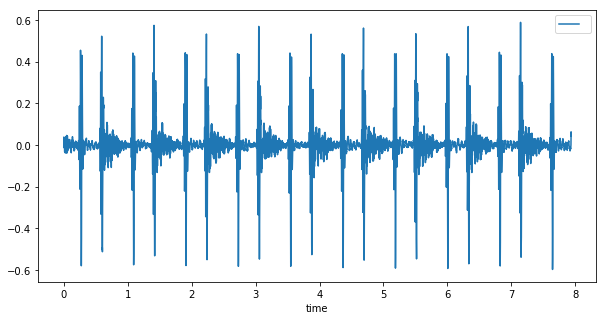

In [76]:
audio1, sfreq1 = lr.load(audio_files[1])
time1 = np.arange(0, len(audio1)) / sfreq1

#combine two arrays and convert to a dataframe
audio=pd.DataFrame(np.column_stack([time1,audio1]),columns=['time','']).set_index('time')
#or, audio=pd.DataFrame({'time':time1,'':audio1}).set_index('time')
audio.plot(figsize=(10,5));

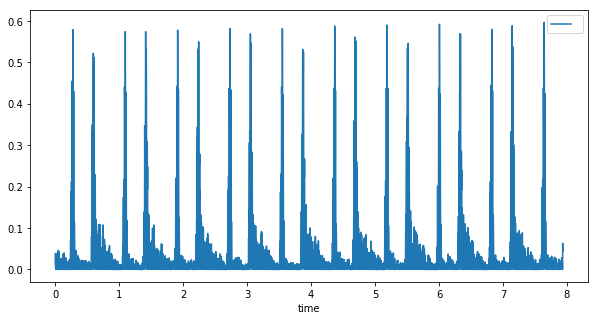

In [77]:
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)

# Plot the result
audio_rectified.plot(figsize=(10, 5))
plt.show()

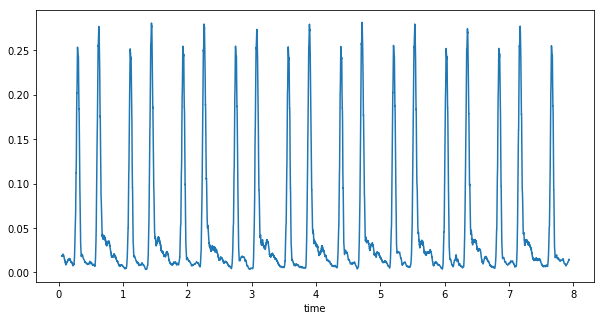

In [82]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(1000).mean()

# Plot the result
audio_rectified_smooth.plot(figsize=(10, 5),legend=False)
plt.show()

By calculating the envelope of each sound and smoothing it, we've eliminated much of the noise and have a cleaner signal to tell when a heartbeat is happening.

# Calculating features from the envelope
Now that we've removed some of the noisier fluctuations in the audio, let's see if this improves your ability to classify.



In [ ]:
# Calculate stats
means = np.mean(audio_rectified_smooth, axis=0)
stds = np.std(audio_rectified_smooth, axis=0)
maxs = np.max(audio_rectified_smooth, axis=0)

# Create the X and y arrays
X = np.column_stack([means, stds, maxs])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.714219114219<br>
This model is both simpler (only 3 features) and more understandable (features are simple summary statistics of the data).

# Derivative features: The tempogram
One benefit of cleaning up the data is that it lets us compute more sophisticated features. For example, the envelope calculation we performed is a common technique in computing tempo and rhythm features. In this exercise, we'll use librosa to compute some tempo and rhythm features for heartbeat data, and fit a model once more.

Note that librosa functions tend to only operate on numpy arrays instead of DataFrames, so we'll access our Pandas data as a Numpy array with the .values attribute.

In [ ]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)


# Create the X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.518065268065

Note that our predictive power may not have gone up (because this dataset is quite small), but we now have a more rich feature representation of audio that our model can use

# The spectrogram- spectrum changes to sound over time
Timeseries data can be described as a combination of quickly-chaning things and slowly-changing things. At each moment in time, we can describe the relative presence of fast- and slow- moving components by Fourier transformation.
Fourier transforms converts a single timeseries into an array that describes the timeseries as a combination of oscillations.

A spectrogram is a collection of windowed Fourier transforms over time
Similar to how a rolling mean was calculated:
1. Choose a window size and shape
2. At a timepoint, calculate the FFT for that window
3. Slide the window over by one
4. Aggregate the results

Called a Short-Time Fourier Transform (STFT). We can calculate the STFT with librosa.
There are several parameters we can tweak (such as window size). For our purposes, we'll convert into decibels which normalizes the average values of all frequencies. We can then visualize it with the specshow() function

**Spectral feature engineering**<br>
Each timeseries has a different spectral pattern.
We can calculate these spectral patterns by analyzing the spectrogram.
For example, spectral bandwidth and spectral centroids describe where most of the energy is at each moment in time.

# Spectrograms of heartbeat audio
Spectral engineering is one of the most common techniques in machine learning for time series data. The first step in this process is to calculate a spectrogram of sound. This describes what spectral content (e.g., low and high pitches) are present in the sound over time. Let's calculate a spectrogram of a heartbeat audio file.

In [92]:
# Import the functions you'll use for the STFT
from librosa.core import stft

audio=audio0[:8820]#.shape
time=time0[:8820]
sfreq=2205

# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert into decibels
spec_db = amplitude_to_db(spec)

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
plt.show()

![png](img/spec.png)
Do you notice that the heartbeats come in pairs, as seen by the vertical lines in the spectrogram?

# Engineering spectral features
As you can probably tell, there is a lot more information in a spectrogram compared to a raw audio file. By computing the spectral features, we have a much better idea of what's going on. As such, there are all kinds of spectral features that we can compute using the spectrogram as a base. Next, we'll look at a few of these features.

In [ ]:
from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
ax.plot(times_spec, centroids)
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

![png](img/spec2.png)
As you can see, the spectral centroid and bandwidth characterize the spectral content in each sound over time. They give us a summary of the spectral content that we can use in a classifier.

# Combining many features in a classifier
We've engineered many features from the audio data - some contain information about how the audio changes in time, others contain information about the spectral content that is present.

The beauty of machine learning is that it can handle all of these features at the same time. If there is different information present in each feature, it should improve the classifier's ability to distinguish the types of audio. Note that this often requires more advanced techniques such as regularization, which we'll cover in the next section.

We've loaded many of the features that we calculated before. Combine all of them into an array that can be fed into the classifier, and see how it does.



In [ ]:
# Loop through each spectrogram
bandwidths = []
centroids = []

for spec in spectrograms:
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    # Collect the values
    bandwidths.append(this_mean_bandwidth)  
    centroids.append(this_mean_centroid)
    
# Create X and y arrays
X = np.column_stack([means, stds, maxs, tempo_mean, tempo_max, tempo_std, bandwidths, centroids])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))    

0.501398601399

We calculated many different features of the audio, and combined each of them under the assumption that they provide independent information that can be used in classification. We also noticed that the accuracy of our models varied a lot when using different set of features. So far we focused on creating new "features" from raw data and not obtaining the best accuracy. To improve the accuracy, we want to find the right features that provide relevant information and also build models on much larger data.



____________

# The New York stock exchange dataset
This dataset consists of company stock values for 10 years. Can we detect any patterns in historical records that allow us to predict the value of companies i the future? We'll visualize the raw data for the two companies (Ebay and Yahoo), then generate a scatter plot showing how the values for each company compare with one another. We'll also add in a "time" dimension to our scatter plot so we can see how this relationship changes over time.

In [1]:
import pandas as pd
# Read in the data
data = pd.read_csv('/Users/phyhouhou/prices.csv', index_col=0)

# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)
print(data.head())

           symbol        open       close         low        high     volume
date                                                                        
2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002  2006300.0
2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002  1408600.0


In [6]:
df=data[data.symbol.isin(['YHOO','EBAY'])][['symbol','close']].reset_index()

prices=df.pivot(index='date',columns='symbol')['close']
#df.pivot_table(values='close',index='date',columns='symbol')
#df.groupby(['date','symbol'])['close'].mean().unstack()
prices.head()

symbol,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


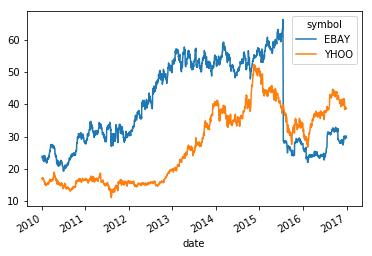

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline



# Plot the raw values over time
prices.plot()
plt.show()

Note there are a lot of 'jumps' in there - what effect these jumps would have on a predictive model?

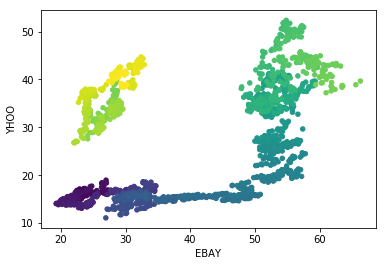

In [10]:
# Scatterplot with one company per axis and color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, 
                    cmap=plt.cm.viridis, colorbar=False)
plt.show()

As you can see, these two time series seem somewhat related to each other, though its a complex relationship that changes over time.

# Fitting a simple regression model
Now we'll look at a larger number of companies. Recall that we have historical price values for many companies. Let's use data from several companies to predict the value of a test company. We will attempt to predict the value of the Apple stock price using the values of NVidia, Ebay, and Yahoo. Each of these is stored as a column in the prices DataFrame. Below is a mapping from company name to column name:

ebay: "EBAY"<br>
nvidia: "NVDA"<br>
yahoo: "YHOO"<br>
apple: "AAPL"<br>


In [12]:
df=data[data.symbol.isin(['YHOO','EBAY','NVDA','AAPL'])][['symbol','close']].reset_index()

all_prices=df.pivot(index='date',columns='symbol')['close']
#df.pivot_table(values='close',index='date',columns='symbol')
#df.groupby(['date','symbol'])['close'].mean().unstack()
all_prices.head()

symbol,AAPL,EBAY,NVDA,YHOO
date,,,,
2010-01-04,214.009998,23.900000,18.490000,17.100000
2010-01-05,214.379993,23.650000,18.760000,17.230000
2010-01-06,210.969995,23.500000,18.879999,17.170000
2010-01-07,210.580000,23.229998,18.510000,16.700001
2010-01-08,211.980005,23.509999,18.549999,16.700001


In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use stock symbols to extract training data
X = all_prices[['EBAY','NVDA','YHOO']]
y = all_prices[['AAPL']]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[  -0.55495235   -0.9912733  -322.41700994]


As you can see, fitting a model with raw data doesn't give great results.

# Visualizing predicted values
When dealing with time series data, it's useful to visualize model predictions on top of the "actual" values that are used to test the model.

 After splitting the data (stored in the variables X and y) into training and test sets, we will build a model and then visualize the model's predictions on top of the testing data in order to estimate the model's performance.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

-3308.6687638451976


/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


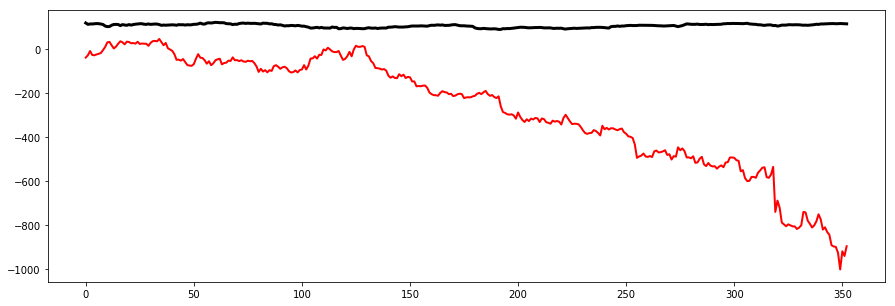

In [19]:
# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.values, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()

We have an explanation for our poor score. The predictions clearly deviate from the true time series values.

# Advanced time series predictions
**Interpolation in Pandas**

**Using a rolling window to transform data**
Another common use of rolling windows is to transform the data. We've already done this once, in order to smooth the data. However, we can also use this to do more complex transformations

**Transforming data to standardize variance**
A common transformation to apply to data is to standardize its mean and variance over time. There are many ways to do this. Here, we'll show how to convert our dataset so that each point represents the % change over a previous window.
This makes timepoints more comparable to one another if the absolute values of data change a lot.


**Transforming to percent change with Pandas**

**Replacing outliers using the threshold**

# Visualizing messy data
Let's take a look at a new dataset - this one is a bit less-clean than what we've seen before.

As always, we'll first start by visualizing the raw data. Take a close look and try to find data points that could be problematic for fitting models.

In [42]:
df=data[data.symbol.isin(['YHOO','EBAY','NVDA'])][['symbol','close']].reset_index()

prices=df.pivot(index='date',columns='symbol')['close']
#df.pivot_table(values='close',index='date',columns='symbol')
#df.groupby(['date','symbol'])['close'].mean().unstack()
import numpy as np
prices.loc['2013':'2014',:]=np.nan
prices.head()

symbol,EBAY,NVDA,YHOO
date,,,
2010-01-04,23.900000,18.490000,17.100000
2010-01-05,23.650000,18.760000,17.230000
2010-01-06,23.500000,18.879999,17.170000
2010-01-07,23.229998,18.510000,16.700001
2010-01-08,23.509999,18.549999,16.700001


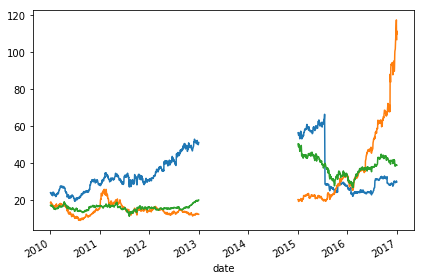

symbol
EBAY    504
NVDA    504
YHOO    504
dtype: int64


In [43]:
# Visualize the dataset
prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices.isnull().sum()
print(missing_values)

# Imputing missing values
When there are missing data points, how can we fill them in? Next let's practice using different interpolation methods to fill in some missing values, visualizing the result each time. But first, we will create the function (interpolate_and_plot()) we'll use to interpolate missing data points and plot them.

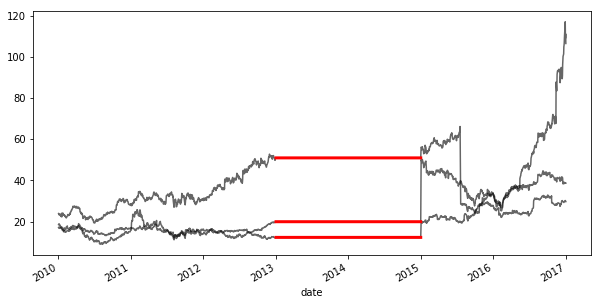

In [44]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)
#Interpolation using the latest non-missing value is labelled 'zero' in Pandas.    

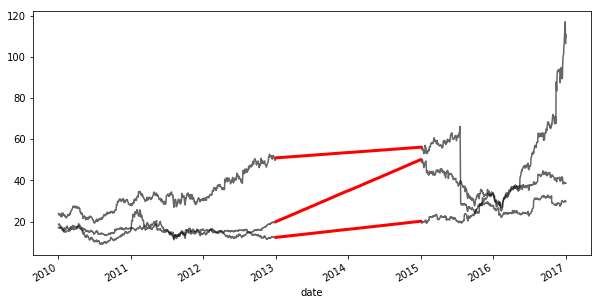

In [45]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices, interpolation_type)

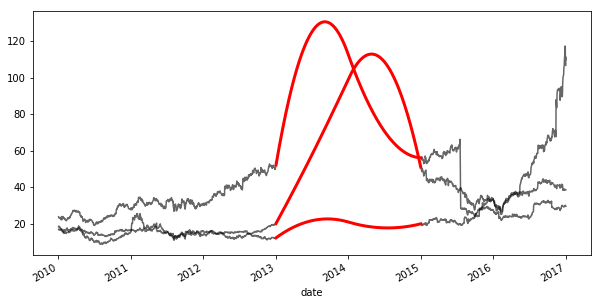

In [46]:
# Interpolate with a quadratic function
interpolation_type = 'quadratic'
interpolate_and_plot(prices, interpolation_type)

When you interpolate, the pre-existing data is used to infer the values of missing data. As you can see, the method we use for this has a big effect on the outcome.

# Transforming raw data
In the last section, we calculated the rolling mean. In this exercise, we define a function that calculates the percent change of the latest data point from the mean of a window of previous data points. This function will help to calculate the percent change over a rolling window. This is a more stable kind of time series that is often useful in machine learning.

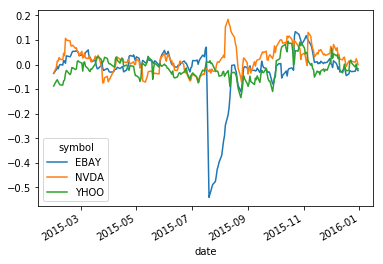

In [88]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).aggregate(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

We've converted the data so it's easier to compare one time point to another. This is a cleaner representation of the data.

# Handling outliers
Next we will handle outliers - data points that are so different from the rest of the data, that we treat them differently from other "normal-looking" data points. We'll use the output from the previous exercise (percent change over time) to detect the outliers. First we will write a function that replaces outlier data points with the median value from the entire time series.

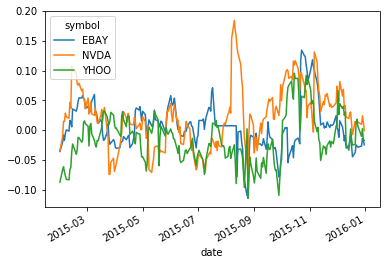

In [89]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

# Creating features over time
**using .aggregate for feature extraction**<br>
#Calculate a rolling window, then extract two features
feats = prices.rolling(20).aggregate([np.std, np.max]).dropna()


**Using partial() in Python**<br>
If we just take the mean, it returns a single value. We can use the partial function to initialize np.mean 
with an axis parameter

from functools import partial
mean_over_first_axis = partial(np.mean, axis=0)


**Percentiles summarize your data**<br>
Percentiles are a useful way to get more fine-grained summaries of your data (as opposed to using np.mean)
For a given dataset, the Nth percentile is the value where N% of the data is below that datapoin, and 100-N% of the data is above that datapoint.

  
**Combining np.percentile() with partial functions to calculate a range of percentiles**<br>

**Calculating "date-based" features**<br>
Thus far we've focused on calculating "statistical" features - these are features that correspond statistical properties of the data, like "mean", "standard deviation", etc
However, don't forget that timeseries data often has more "human" features associated with it, like days of the week, holidays, etc.
These features are often useful when dealing with timeseries data that spans multiple years (such as stock value over time)


**datetime features using Pandas**<br>
#Ensure our index is datetime
prices.index = pd.to_datetime(prices.index)

#Extract datetime features
day_of_week_num = prices.index.weekday
day_of_week = prices.index.weekday_name

# Engineering multiple rolling features at once
Now that we've practiced some simple feature engineering, let's move on to something more complex. We'll calculate a collection of features for our time series data and visualize what they look like over time. This process resembles how many other time series models operate.

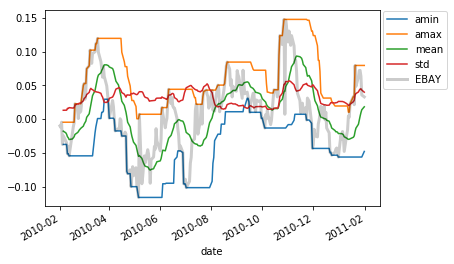

In [90]:
prices_perc=prices_perc.EBAY
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

# Percentiles and partial functions
Let's practice how to pre-choose arguments of a function so that we can pre-configure how it runs. We'll use this to calculate several percentiles of our data using the same percentile() function in numpy.

/Users/phyhouhou/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


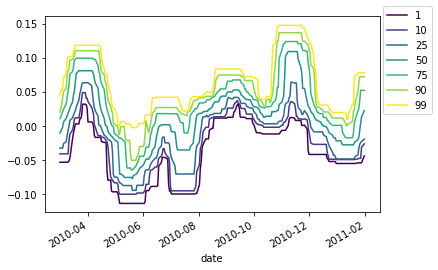

In [91]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

# Using "date" information
It's easy to think of timestamps as pure numbers, but don't forget they generally correspond to things that happen in the real world. That means there's often extra information encoded in the data such as "is it a weekday?" or "is it a holiday?". This information is often useful in predicting timeseries data.

In [95]:
prices_perc=prices_perc.to_frame()
prices_perc.index=pd.to_datetime(prices_perc.index)


# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.weekday
prices_perc['week_of_year'] = prices_perc.index.week
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc.sample(5))

                EBAY  day_of_week  week_of_year  month_of_year
date                                                          
2016-08-03  0.100743            2            31              8
2013-01-15       NaN            1             3              1
2016-01-08 -0.065104            4             1              1
2014-10-20       NaN            0            43             10
2013-04-11       NaN            3            15              4


# Creating features from the past

**Time-delayed features and auto-regressive models**<br>
The past is useful. Timeseries data almost always have information that is shared between timepoints. Information in the past can help predict what happens in the future. Often the features best-suited to predict a timeseries are previous values of the same timeseries.


**A note on smoothness and auto-correlation**<br>
A common question to ask of a timeseries: how smooth is the data.
AKA, how correlated is a timepoint with its neighboring timepoints (called autocorrelation).
The amount of auto-correlation in data will impact your models.

**Creating time-lagged features**<br>
Let's see how we could build a model that uses values in the past as input features. We can use this to assess how auto-correlated our signal is (and lots of other stuff too). We can achieve this by creating a time-shifted DataFrame.

# Creating time-shifted features
In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.

Next we'll "shift" our raw data and visualize the results. We'll use the percent change time series that we calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, we want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time

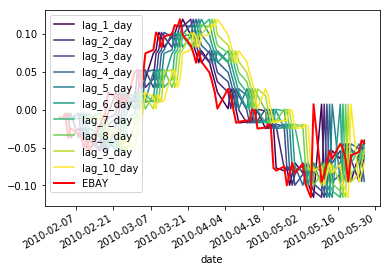

In [100]:
prices_perc=prices_perc.EBAY

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

# Special case: Auto-regressive models
Now that we've created time-shifted versions of a single time series, we can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. We are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, we can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

In [101]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

# Visualize regression coefficients
Now that we've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives us an idea for how the different features of a model affect the outcome.


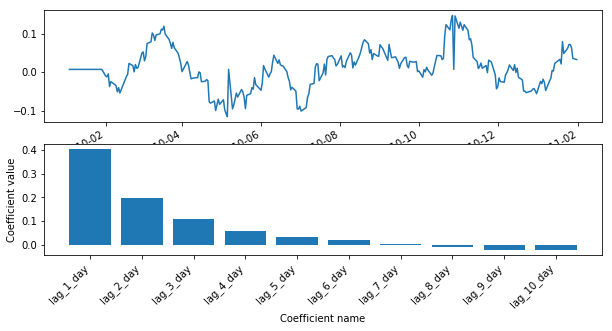

In [102]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

When you use time-lagged features on the raw data, you see that the highest coefficient by far is the first one. This means that the N-1th time point is useful in predicting the Nth timepoint, but no other points are useful.


# Auto-regression with a smoother time series
Now, let's re-run the same procedure using a smoother signal. You'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. What do you think this will do to the auto-regressive model?

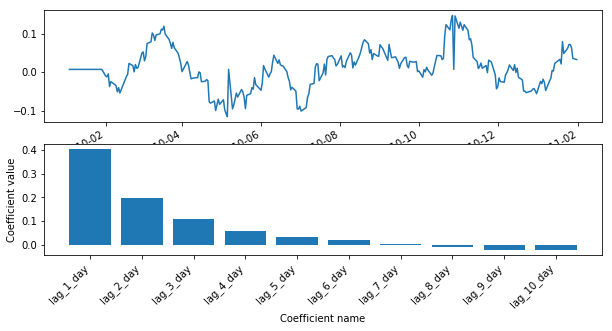

In [103]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

As you can see here, by transforming your data with a larger window, you've also changed the relationship between each timepoint and the ones that come just before it. This model's coefficients gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means your data is not i.i.d.

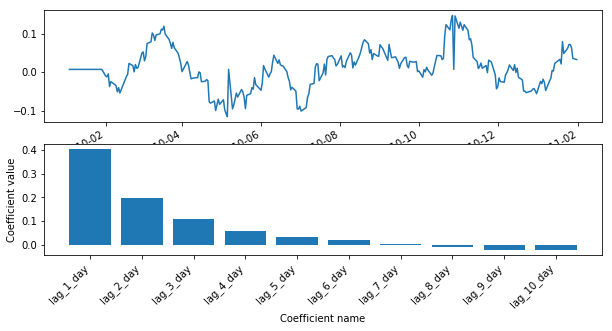

In [114]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

# Cross-validating time series data

**A note on shuffling your data**<br>
Many CV iterators let you shuffle data as a part of the cross-validation process. This only works if the data is i.i.d., which timeseries usually is not. You should not shuffle your data when making predictions with timeseries.
One approach: Always use training data from the past to predict the future

# Cross-validation with shuffling
Cross-validation is the process of splitting the data into training and test sets multiple times. Each time we do this, we choose a different training and test set. We'll perform a traditional ShuffleSplit cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.

An instance of the Linear regression object (model) is available in workspace along with the function r2_score() for scoring. Also, the data is stored in arrays X and y. We've also provided a helper function (visualize_predictions()) to help visualize the results.

In [ ]:
# Import ShuffleSplit and create the cross-validation object
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

![png](img/skfvis2.png)

If you look at the plot to the right, see that the order of datapoints in the test set is scrambled. Let's see how it looks when we shuffle the data in blocks.

# Cross-validation without shuffling
Now, we re-run our model fit using block cross-validation (without shuffling all datapoints). In this case, neighboring time-points will be kept close to one another. How do you think the model predictions will look in each cross-validation loop?



In [ ]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr],y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

![png](img/nskfvis.png)
This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because we didn't shuffle the data. This is a good sanity check to make sure your CV splits are correct.

# Time-based cross-validation
Finally, let's visualize the behavior of the time series cross-validation iterator in scikit-learn. Use this object to iterate through our data one last time, visualizing the training data used to fit the model on each iteration.

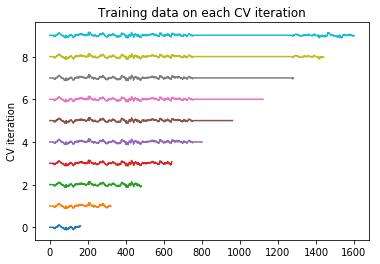

In [128]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

Note that the size of the training set grew each time when we used the time series cross-validation object. This way, the time points we predict are always after the timepoints we train on.


# Stationarity and stability
Stationarity
Stationary time series do not change their statistical properties over time
E.g., mean, standard deviation, trends
Most time series are non-stationary to some extent


# Model stability
Non-stationary data results in variability in our model
The statistical properties the model finds may change with the data
In addition, we will be less certain about the correct values of model parameters
How can we quantify this?


**Cross validation to quantify parameter stability**<br>
One approach: use cross-validation
Calculate model parameters on each iteration
Assess parameter stability across all CV splits


**Bootstrapping the mean**<br>
Bootstrapping is a common way to assess variability
The bootstrap:
Take a random sample of data with replacement
Calculate the mean of the sample
Repeat this process many times (1000s)
Calculate the percentiles of the result (usually 2.5, 97.5)
The result is a 95% confidence interval of the mean of each coefficient.

# Assessing model performance stability
If using the TimeSeriesSplit, can plot the model's score over time.
This is useful in finding certain regions of time that hurt the score
Also useful to find non-stationary signals.

# Bootstrapping a confidence interval
A useful tool for assessing the variability of some data is the bootstrap. In this exercise, you'll write your own bootstrapping function that can be used to return a bootstrapped confidence interval.

This function takes three parameters: a 2-D array of numbers (data), a list of percentiles to calculate (percentiles), and the number of boostrap iterations to use (n_boots). It uses the resample function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.

In [129]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

# Calculating variability in model coefficients
Next we'll re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. We'll investigate the coefficients of the model, as well as the uncertainty in its predictions.

Begin by assessing the stability (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that our model has found in the data.

In [134]:
y=np.array(y).reshape([-1,1])

In [ ]:
# Iterate through CV splits
n_splits = 10
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_
    
    
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()


![png](img/ci.png)
We've calculated the variability around each coefficient, which helps assess which coefficients are more stable over time!

# Visualizing model score variability over time
Now that we've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the TimeSeriesSplit object will use successively-later indices for each test set. This means that we can treat the scores of our validation as a time series. We can visualize this over time in order to see how the model's performance changes over time.

In [ ]:
from sklearn.model_selection import cross_val_score

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))


# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

![png](img/performance.png)
We plotted a rolling confidence interval for scores over time. This is useful in seeing when our model predictions are correct.

# Accounting for non-stationarity
Next we will again visualize the variations in model scores, but now for data that changes its statistics over time.

In [ ]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores
    
    
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()


![png](img/nstat.png)

Notice how in some stretches of time, longer windows perform worse than shorter ones. This is because the statistics in the data have changed, and the longer window is now using outdated information.